<a href="https://colab.research.google.com/github/hazmicokro/Classification-Covid-19-using-CNN/blob/main/%5B1%5D_Classification_COVID_19_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UTS -  Machine Learning 7B** \
Muhammad Rifal Alfarizy (201710370311219)\
Moch Hazmi Cokro Mandiri (201710370311240)

#[0] Hasil Akhir dan Kesimpulan

Pada percobaan kali ini, dilakukan klasifikasi covid19 pada dataset Chest CT scan dengan menggunakan 4 model. Model ke 3 dan 4 merupakan model buatan sendiri yang dibuat untuk meningkatkan akurasi dari model sebelumnya. Pada model 3 dan 4 dilakukan pengujian dari jumlah dan nilai dari layer dropout. Model yang telah dibuat dijelaskan pada rincian sebagai berikut :

Model 1 - Arsitketur MobileNet \
Model 2 - Arsitektur DenseNet 121 \
Model 3 - Penggunaan layer dropout disetiap setelah layer maxpooling dan nilai dropout pada fully connected layer sebesar 0.5 \
Model 4 - Pengurangan jumlah layer dropout disetiap setelah layer maxpooling dan nilai dropout pada fully connected layer sebesar 0.2 \

Hasil dari percobaan ini dapat dilihat pada tabel dan visualisasi akurasi dan train dibawah ini,

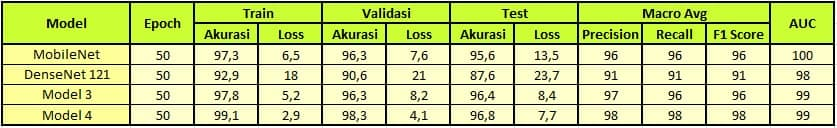

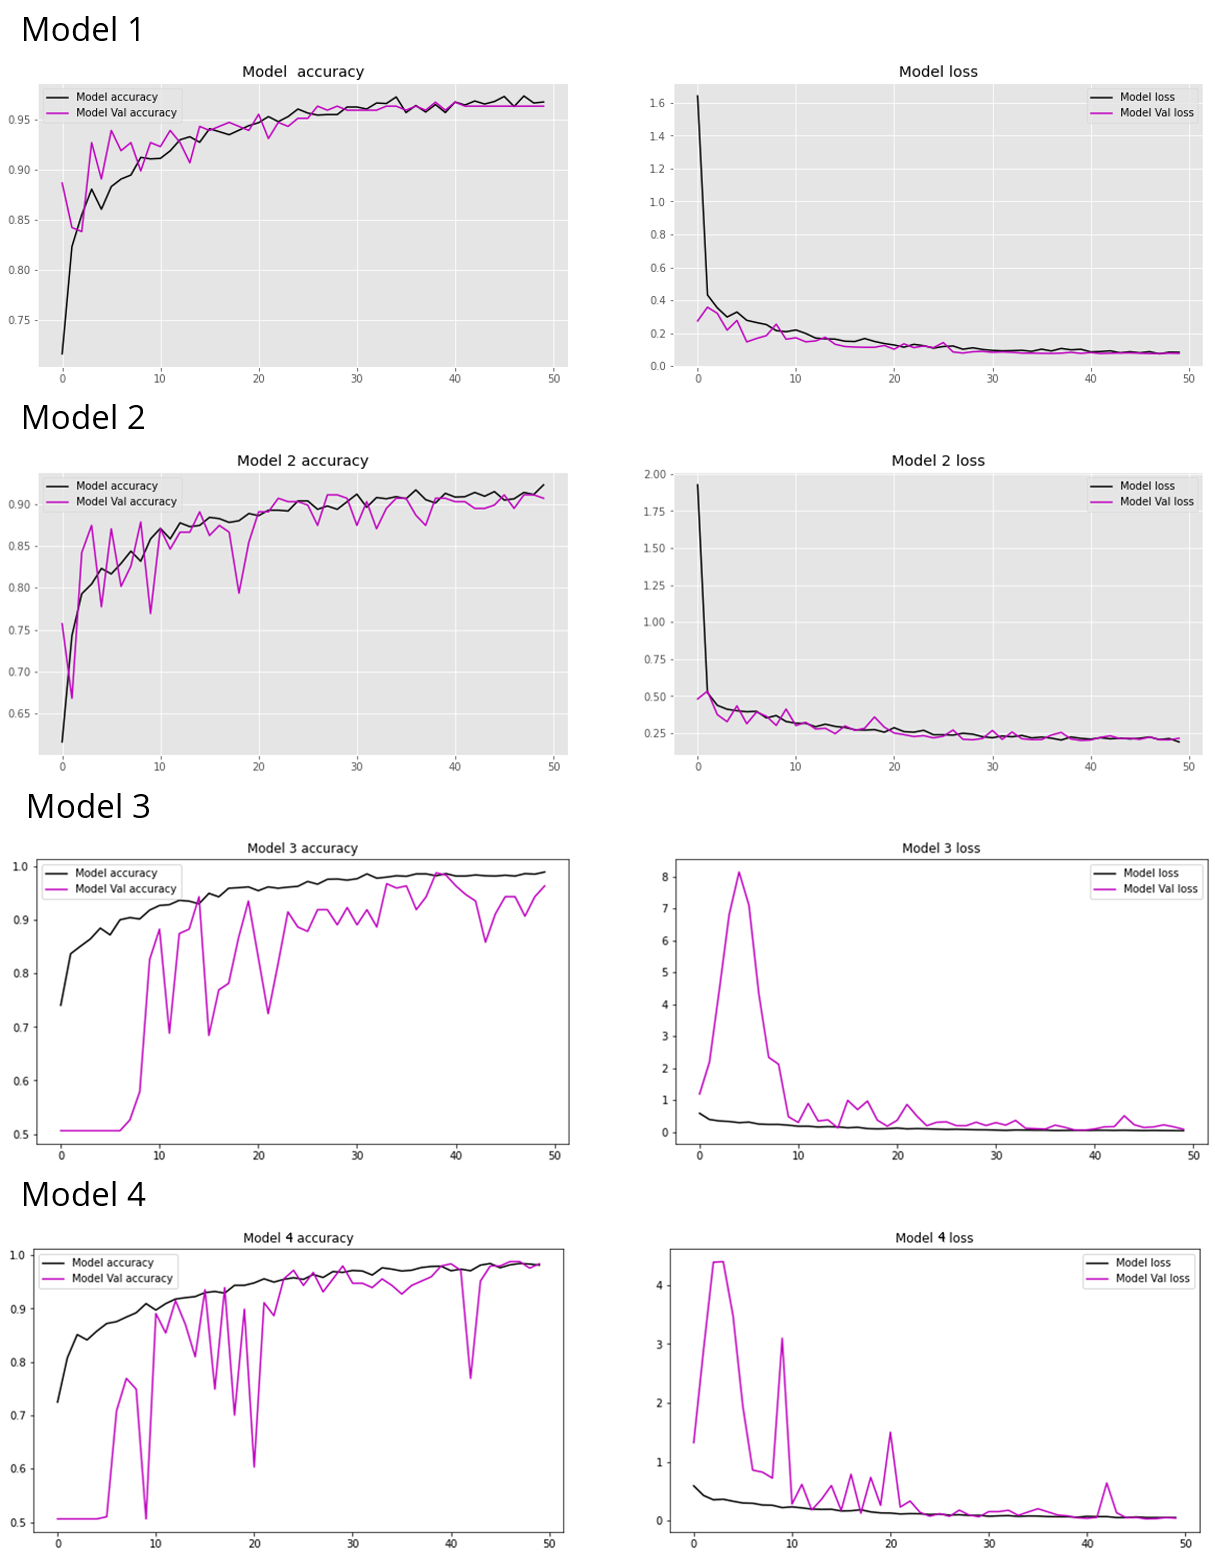

Berdasarkan percobaan, model yang dibuat dapat mengungguli MobileNet dan DenseNet 121 dari segi akurasi dan loss. Namun, pada percobaan Model ke 3 terjadi peningkatan dan penurunan akurasi dan loss pada setiap epoch (tidak stabil) apabila dibandingkan dengan MobileNet dan DenseNet. Kemudian dilakukan percobaan dengan Model ke 4 dengan mengurangi jumlah layer dropout dan nilai dropout pada fully connected layer, namun model ke 4 memiliki peningkatan dan penurunan akurasi dan loss pada setiap epoch yang lebih terlihat daripada model 3, akan tetapi model 4 memiliki akurasi dan loss yang lebih bagus daripada model 3.

# [*] Library

In [ ]:
#Preprocessing, visualisasi dll
import os
import cv2
import shutil
import random
import numpy as np
from pandas import DataFrame
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img

# Training / Fit data
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation,GlobalMaxPool2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.layers import Dropout, Input
from tensorflow.keras.optimizers import Adam
from keras.applications import MobileNet
from keras.applications import DenseNet121
from keras.models import load_model
from tensorflow.keras import callbacks

# Evaluasi
import itertools
from sklearn import metrics
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_score, confusion_matrix, classification_report
from sklearn.metrics import  precision_recall_curve, auc, roc_curve, roc_auc_score

#[1] Preparation

###Mount ke Google drive, Atur Workspace

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Dataset/Dataset ML 219 - 240"

In [ ]:
%cd /content/drive/MyDrive/Dataset/Dataset ML 219 - 240

/content/drive/MyDrive/Dataset/Dataset ML 219 - 240


###Download dan Ekstrak Dataset

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mhazmicokro","key":"2d1770a2c2e7c072dc66fd9fd266c406"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

 98% 225M/230M [00:09<00:00, 24.3MB/s]
100% 230M/230M [00:09<00:00, 26.6MB/s]


In [ ]:
!ls

kaggle.json  sarscov2-ctscan-dataset.zip


In [ ]:
!unzip -q sarscov2-ctscan-dataset.zip 

In [ ]:
!ls

COVID  kaggle.json  non-COVID  sarscov2-ctscan-dataset.zip


In [ ]:
!mkdir DataCovid
print('Sukses buat folder DataCovid')
!mv COVID non-COVID -t DataCovid
print('\nSukses memindahkan Covid - Non Covid ke folder DataCovid')

Sukses buat folder DataCovid

Sukses memindahkan Covid - Non Covid ke folder DataCovid


In [ ]:
!mkdir Dataset
print('Sukses buat folder Dataset Covid')

Sukses buat folder Dataset Covid


###Split Dataset 

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio('/content/drive/MyDrive/Dataset/Dataset ML 219 - 240/DataCovid', output='/content/drive/MyDrive/Dataset/Dataset ML 219 - 240/Dataset',
                   seed=121, ratio=(.8, .1, .1), group_prefix=None)

Copying files: 2481 files [00:39, 63.46 files/s]


Mengecek Ukuran Gambar

In [ ]:
from PIL import Image

im = Image.open('/content/drive/MyDrive/Dataset/Dataset ML 219 - 240/Dataset/train/COVID/Covid (1001).png')
im2 = Image.open('/content/drive/MyDrive/Dataset/Dataset ML 219 - 240/Dataset/test/non-COVID/Non-Covid (1016).png')
print(im.size)
print(im2.size)

(333, 308)
(311, 217)


#[2] Preprocessing

###Plot Random Image tiap Kelas

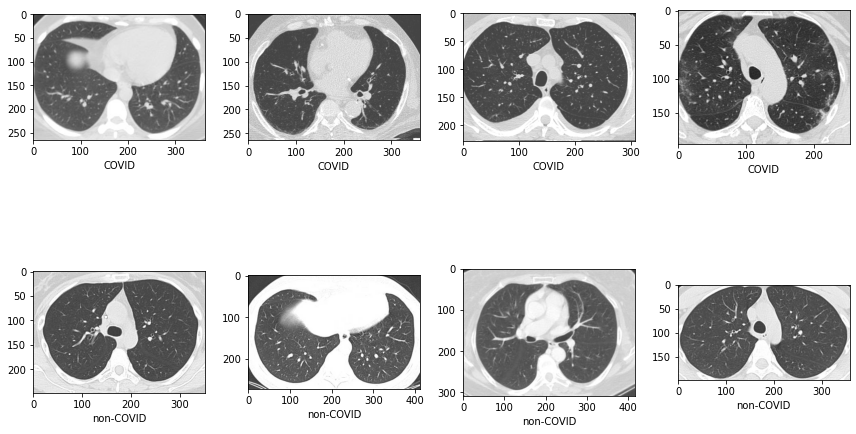

In [ ]:
covid_dir = os.path.join("/content/drive/MyDrive/Dataset/Dataset ML 219 - 240/Dataset/val/COVID/")  
noncovid_dir = os.path.join("/content/drive/MyDrive/Dataset/Dataset ML 219 - 240/Dataset/val/non-COVID/")

list1 = [covid_dir,noncovid_dir]

fig = plt.figure(figsize=(12, 8))

j=1
for i in list1: 
    for k in range(4):
        filenames  = os.listdir(i)
        sample = random.choice(filenames)
        image = load_img(i+sample)
        plt.subplot(2,4,j)
        plt.imshow(image)
        plt.xlabel(i.split("/")[-2])
        j+=1
plt.tight_layout()

##Gather Data, Resize image

In [ ]:
training_dir = r"/content/drive/MyDrive/Dataset/Dataset ML 219 - 240/Dataset/train/"
validation_dir = r"/content/drive/MyDrive/Dataset/Dataset ML 219 - 240/Dataset/val/"
testing_dir = r"/content/drive/MyDrive/Dataset/Dataset ML 219 - 240/Dataset/test/"

categories = ['non-COVID', 'COVID']

In [ ]:
img_size = (128,128)

training_data = []
validation_data = []
testing_data = []

def create_training_data():
    for category in categories:
        path = os.path.join(training_dir,category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,img_size) 
                training_data.append([new_array,class_num])
            except Exception as e:
                pass

def create_validation_data():
    for category in categories:
        path = os.path.join(validation_dir,category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,img_size) 
                validation_data.append([new_array,class_num])
            except Exception as e:
                pass

def create_testing_data():
    for category in categories:
        path = os.path.join(testing_dir,category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img))
                new_array = cv2.resize(img_array,img_size) 
                testing_data.append([new_array,class_num])
            except Exception as e:
                pass


create_training_data()
print("Berhasil Create Training Data")
create_validation_data()
print("Berhasil Create Validation Data")
create_testing_data()
print("Berhasil Create Validation Data")

Berhasil Create Training Data
Berhasil Create Validation Data
Berhasil Create Validation Data


In [ ]:
X_train = []
Y_train = []
for features,label in training_data:
    X_train.append(features)
    Y_train.append(label)
X_train = np.array(X_train).reshape(-1,128,128)
X_train = X_train.astype('float32')/255.0  
X_train = X_train.reshape(-1,128,128,3)
print(X_train.shape)

X_val = []
Y_val = []
for features,label in validation_data:
    X_val.append(features)
    Y_val.append(label)
X_val = np.array(X_val).reshape(-1,128,128)
X_val = X_val.astype('float32')/255.0  
X_val = X_val.reshape(-1,128,128,3)
print(X_val.shape)

X_test = []
Y_test = []
for features,label in testing_data:
    X_test.append(features)
    Y_test.append(label)
X_test = np.array(X_test).reshape(-1,128,128)
X_test = X_test.astype('float32')/255.0  
X_test = X_test.reshape(-1,128,128,3)
print(X_test.shape)

(1984, 128, 128, 3)
(247, 128, 128, 3)
(250, 128, 128, 3)


In [ ]:
Y_train = np.array(Y_train)
Y_val = np.array(Y_val)
Y_test = np.array(Y_test)
Y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

#[3] Processing

##Model 1 MobileNet

In [ ]:
base_model = MobileNet(include_top=False,weights='imagenet',input_shape=(128,128,3))

model_mobnet = Sequential([
                           base_model, 
                           Flatten(), 
                           Dense(512,activation=('relu'),input_dim=128),
                           Dense(256,activation=('relu')),
                           Dropout(0.5),     
                           Dense(1,activation=('sigmoid'))
])
model_mobnet.layers[0].trainable = False

model_mobnet.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
flatten_6 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 257       
Total params: 11,749,569
Trainable params: 8,520,705
Non-trainable params: 3,228,864
___________________________________

In [ ]:
Adam(learning_rate=0.00146, name='Adam')
model_mobnet.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

In [ ]:
epochs = 50  
batch_size = 32

datagen = ImageDataGenerator(
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,  
        vertical_flip=False)  

### Training Model 1 / Fit

In [ ]:
import time

start = time.time()
datagen.fit(X_train)
history1 = model_mobnet.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks=[lr_schedule,tb_callback])
stop = time.time()


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/50
62/62 [==============================] - 32s 518ms/step - loss: 1.6417 - accuracy: 0.7157 - val_loss: 0.2740 - val_accuracy: 0.8866

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/50
62/62 [==============================] - 32s 520ms/step - loss: 0.4318 - accuracy: 0.8231 - val_loss: 0.3574 - val_accuracy: 0.8421

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/50
62/62 [==============================] - 32s 514ms/step - loss: 0.3538 - accuracy: 0.8548 - val_loss: 0.3205 - val_accuracy: 0.8381

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/50
62/62 [==============================] - 32s 515ms/step - loss: 0.2977 - accuracy: 0.8805 - val_loss: 0.2179 - val_accuracy: 0.9271

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epo

In [ ]:
model_mobnet.save('model_mobnet_1.h5')

In [ ]:
model_mobnet = load_model('model_mobnet_1.h5')

### Plot Visualisasi Model 1

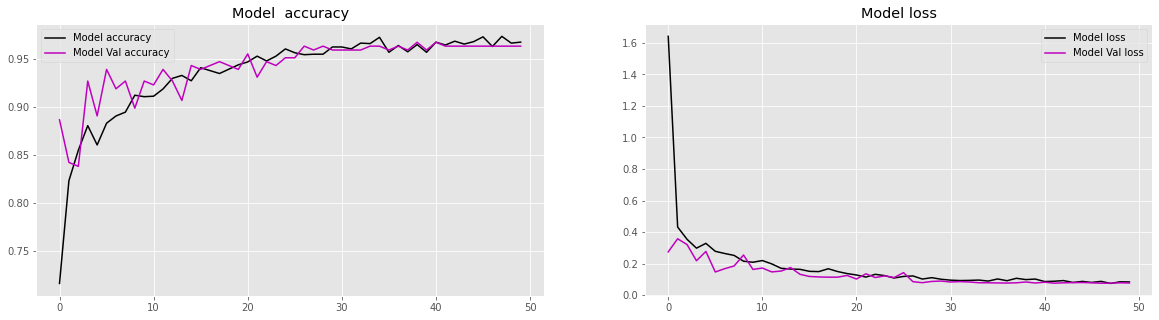

In [ ]:
acc = history1.history["accuracy"]
val_acc = history1.history["val_accuracy"]
loss = history1.history["loss"]
val_loss = history1.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model  accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

### Evaluasi Model 1

In [ ]:
loss, acc = model_mobnet.evaluate(X_train,Y_train,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.06506 dan Training Accuracy 97.38%


In [ ]:
loss, acc = model_mobnet.evaluate(X_val,Y_val,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Validation Loss 0.07667 dan Validation Accuracy 96.36%


In [ ]:
loss, acc = model_mobnet.evaluate(X_test,Y_test,verbose = 0)
print("Test Loss {:.5f} dan Test Accuracy {:.2f}%".format(loss,acc*100))

Test Loss 0.13511 dan Test Accuracy 95.60%


In [ ]:
print("model 1")
pred = model_mobnet.predict(X_val)
labels = (pred > 0.5).astype(np.int)

print(classification_report(Y_val, labels, target_names = categories))

model 1
              precision    recall  f1-score   support

   non-COVID       0.97      0.96      0.96       122
       COVID       0.96      0.97      0.96       125

    accuracy                           0.96       247
   macro avg       0.96      0.96      0.96       247
weighted avg       0.96      0.96      0.96       247



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 1


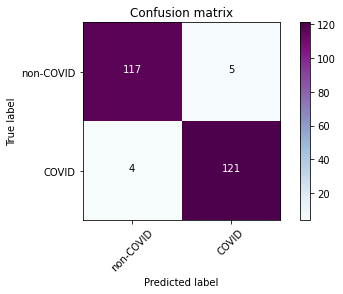

In [ ]:
confusion_mtx = confusion_matrix(Y_val, labels)
print("Model 1")
plot_confusion_matrix(confusion_mtx, classes = categories) 

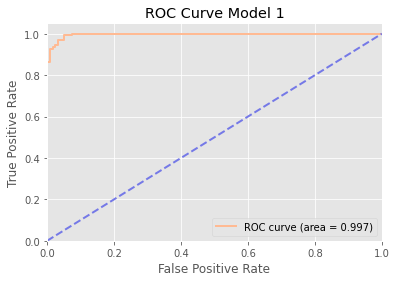

In [ ]:
pred_val = model_mobnet.predict_proba(X_val)
fpr, tpr, _ = roc_curve(Y_val, pred_val)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='#ffba93',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#7579e7', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model 1')
plt.legend(loc="lower right")
plt.show()

In [ ]:
auc_score = roc_auc_score(Y_val, pred_val)
fpr, tpr, th = roc_curve(Y_val, pred_val)
print('AUC Score Model 1 = ', round(auc_score, 3))

AUC Score Model 1 =  0.997


##Model 2 DenseNet121

In [ ]:
base_model2 = DenseNet121(include_top=False,weights='imagenet',input_shape=(128,128,3))

model_DenseNet = Sequential([
                           base_model2, 
                           Flatten(), 
                           Dense(512,activation=('relu'),input_dim=128),
                           Dense(256,activation=('relu')),
                           Dropout(0.5),     
                           Dense(1,activation=('sigmoid'))
])
model_DenseNet.layers[0].trainable = False

model_DenseNet.summary()

29089792/29084464 [==============================] - 2s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
flatten_7 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 512)               8389120   
_________________________________________________________________
dense_20 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_22 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 15,558,209
Trainable params: 8,520,705
No

In [ ]:
Adam(learning_rate=0.00146, name='Adam')
model_DenseNet.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

In [ ]:
epochs = 50  
batch_size = 32

datagen = ImageDataGenerator(
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,  
        vertical_flip=False)  

###Training Model 2 / Fit

In [ ]:
import time

start = time.time()
datagen.fit(X_train)
history2 = model_DenseNet.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks=[lr_schedule,tb_callback])
stop = time.time()


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/50
62/62 [==============================] - 102s 2s/step - loss: 1.9263 - accuracy: 0.6159 - val_loss: 0.4810 - val_accuracy: 0.7571

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/50
62/62 [==============================] - 98s 2s/step - loss: 0.5244 - accuracy: 0.7429 - val_loss: 0.5344 - val_accuracy: 0.6680

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/50
62/62 [==============================] - 97s 2s/step - loss: 0.4383 - accuracy: 0.7928 - val_loss: 0.3758 - val_accuracy: 0.8421

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 4/50
62/62 [==============================] - 98s 2s/step - loss: 0.4120 - accuracy: 0.8044 - val_loss: 0.3278 - val_accuracy: 0.8745

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 5/50
62/

In [ ]:
model_DenseNet.save('model_DenseNet_2.h5')

In [ ]:
model_DenseNet = load_model('model_DenseNet_2.h5')

### Plot Visualisasi Model 2

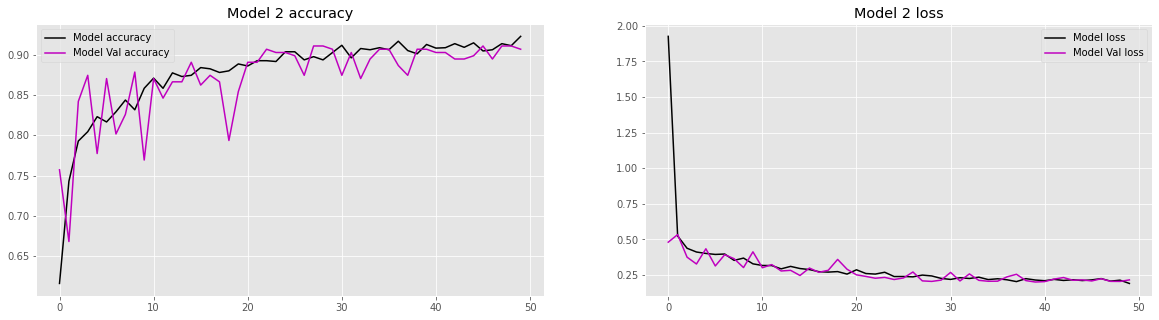

In [ ]:
acc = history2.history["accuracy"]
val_acc = history2.history["val_accuracy"]
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 2 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 2 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

### Evaluasi Model 2

In [ ]:
loss, acc = model_DenseNet.evaluate(X_train,Y_train,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.18322 dan Training Accuracy 92.99%


In [ ]:
loss, acc = model_DenseNet.evaluate(X_val,Y_val,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Validation Loss 0.21616 dan Validation Accuracy 90.69%


In [ ]:
loss, acc = model_DenseNet.evaluate(X_test,Y_test,verbose = 0)
print("Test Loss {:.5f} dan Test Accuracy {:.2f}%".format(loss,acc*100))

Test Loss 0.23709 dan Test Accuracy 87.60%


In [ ]:
print("model 2")
pred = model_DenseNet.predict(X_val)
labels = (pred > 0.5).astype(np.int)

print(classification_report(Y_val, labels, target_names = categories))

model 2
              precision    recall  f1-score   support

   non-COVID       0.96      0.84      0.90       122
       COVID       0.86      0.97      0.91       125

    accuracy                           0.91       247
   macro avg       0.91      0.91      0.91       247
weighted avg       0.91      0.91      0.91       247



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 2


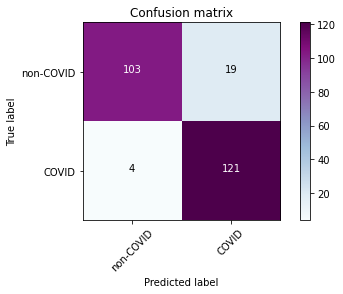

In [ ]:
confusion_mtx = confusion_matrix(Y_val, labels)
print("Model 2")
plot_confusion_matrix(confusion_mtx, classes = categories) 

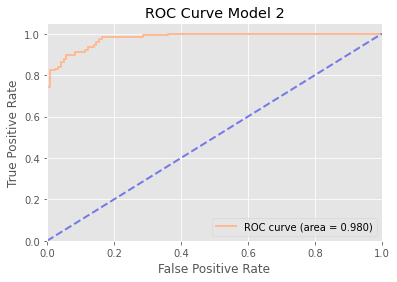

In [ ]:
pred_val = model_DenseNet.predict(X_val)
fpr, tpr, _ = roc_curve(Y_val, pred_val)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='#ffba93',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#7579e7', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model 2')
plt.legend(loc="lower right")
plt.show()

In [ ]:
auc_score = roc_auc_score(Y_val, pred_val)
fpr, tpr, th = roc_curve(Y_val, pred_val)
print('AUC Score Model 2 = ', round(auc_score, 3))

AUC Score Model 2 =  0.98


##Model 3 CNN + Batch Normalization + Maxpool

In [ ]:
model3 = Sequential(
      [
      Input(shape=(128,128,3)),

      Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(0.05),

      Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(0.05),   

      Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(0.05),

      Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(0.05),
       
      Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(0.05),

      Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(0.05),
       
      Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(0.05),
       
      GlobalMaxPool2D(),
      Dropout(0.05),
      Flatten(),

      Dense(128, activation = 'relu'),
      Dense(1, activation='sigmoid')
      ]
  )

In [ ]:
Adam(learning_rate=0.00146, name='Adam')
model3.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)
tb_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True, write_images=False,
    update_freq='epoch', embeddings_freq=0,
    embeddings_metadata=None
)

In [ ]:
epochs = 50  
batch_size = 32

datagen = ImageDataGenerator(
        rotation_range = 10,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,  
        vertical_flip=False)  

### Training Model 3 / Fit

In [ ]:
import time

start = time.time()
datagen.fit(X_train)
history3 = model3.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks=[lr_schedule, tb_callback])
stop = time.time()

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/50
 1/62 [..............................] - ETA: 0s - loss: 0.8711 - accuracy: 0.4375WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
62/62 [==============================] - 8s 131ms/step - loss: 0.5803 - accuracy: 0.7404 - val_loss: 1.1845 - val_accuracy: 0.5061

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/50
62/62 [==============================] - 7s 117ms/step - loss: 0.3862 - accuracy: 0.8367 - val_loss: 2.1857 - val_accuracy: 0.5061

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/50
62/62 [=======

In [ ]:
model3.save('model_3_2.h5')

In [ ]:
model3 = load_model('model_3_2.h5')

### Plot Visualisasi Model 3

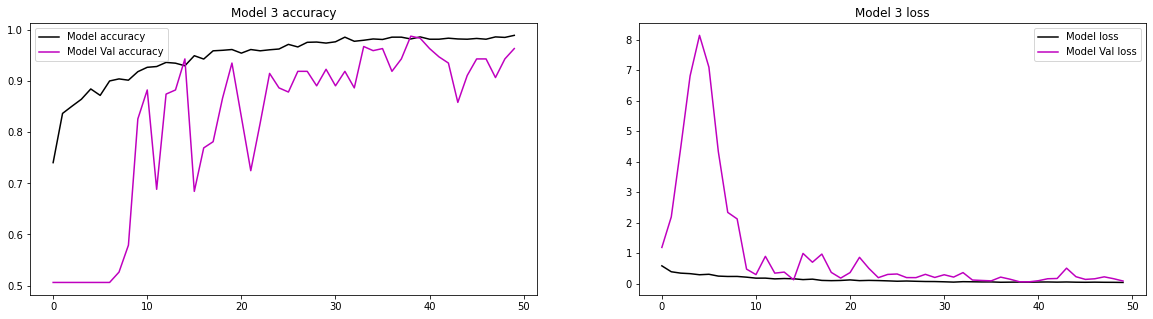

In [ ]:
acc = history3.history["accuracy"]
val_acc = history3.history["val_accuracy"]
loss = history3.history["loss"]
val_loss = history3.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 3 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 3 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

### Evaluasi Model 3

In [ ]:
loss, acc = model3.evaluate(X_train,Y_train,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.05211 dan Training Accuracy 97.83%


In [ ]:
loss, acc = model3.evaluate(X_val,Y_val,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Validation Loss 0.08248 dan Validation Accuracy 96.36%


In [ ]:
loss, acc = model3.evaluate(X_test,Y_test,verbose = 0)
print("Test Loss {:.5f} dan Test Accuracy {:.2f}%".format(loss,acc*100))

Test Loss 0.08495 dan Test Accuracy 96.40%


In [ ]:
print("model 3")
pred = model3.predict(X_val)
labels = (pred > 0.5).astype(np.int)

print(classification_report(Y_val, labels, target_names = categories))

model 3
              precision    recall  f1-score   support

   non-COVID       0.99      0.93      0.96       122
       COVID       0.94      0.99      0.96       125

    accuracy                           0.96       247
   macro avg       0.97      0.96      0.96       247
weighted avg       0.97      0.96      0.96       247



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 3


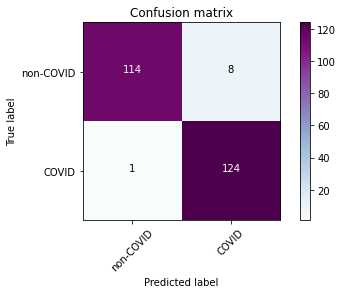

In [ ]:
confusion_mtx = confusion_matrix(Y_val, labels)
print("Model 3")
plot_confusion_matrix(confusion_mtx, classes = categories) 

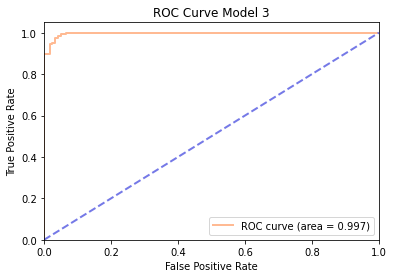

In [ ]:
pred_val = model3.predict(X_val)
fpr, tpr, _ = roc_curve(Y_val, pred_val)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='#ffba93',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#7579e7', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model 3')
plt.legend(loc="lower right")
plt.show()

In [ ]:
auc_score = roc_auc_score(Y_val, pred_val)
fpr, tpr, th = roc_curve(Y_val, pred_val)
print('AUC Score Model 3 = ', round(auc_score, 3))

AUC Score Model 3 =  0.997


##Model 4 CNN + Batch Normalization + Maxpool

In [ ]:
model4 = Sequential(
      [
      Input(shape=(128,128,3)),

      Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),

      Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(0.05),

      Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),

      Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(0.05),

      Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(0.05),
       
      Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu'),
      BatchNormalization(),
      MaxPooling2D(pool_size = (2,2)),
      Dropout(0.05),
       
      GlobalMaxPool2D(),
      Flatten(),

      Dense(256, activation = 'relu'),
      Dense(128, activation = 'relu'),
      Dropout(0.2),
      Dense(1, activation='sigmoid')
      ]
  )

In [ ]:
Adam(learning_rate=0.00146, name='Adam')
model4.compile(optimizer = 'Adam',loss = 'binary_crossentropy',metrics = ['accuracy'])

In [ ]:
filepath="/content/drive/MyDrive/Dataset/Dataset ML 219 - 240/model_3_2.h5"

checkpoint = callbacks.ModelCheckpoint(
                                       filepath,
                                       monitor='val_accuracy',
                                       verbose=1,
                                       save_best_only=True,
                                       mode='auto',
                                       )

def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * tf.math.exp(-0.1)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

In [ ]:
epochs = 50  
batch_size = 32

datagen = ImageDataGenerator(
        rotation_range = 30,
        zoom_range = 0.2,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,  
        vertical_flip=False)  

### Training Model 4 / Fit

In [ ]:
import time

start = time.time()
datagen.fit(X_train)
history4 = model4.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              steps_per_epoch = X_train.shape[0] // batch_size,
                              callbacks=[lr_schedule, checkpoint])
stop = time.time()


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 1/50
62/62 [==============================] - ETA: 0s - loss: 0.5901 - accuracy: 0.7248
Epoch 00001: val_accuracy improved from -inf to 0.50607, saving model to /content/drive/MyDrive/Dataset/Dataset ML 219 - 240/model_3_2.h5
62/62 [==============================] - 11s 173ms/step - loss: 0.5901 - accuracy: 0.7248 - val_loss: 1.3244 - val_accuracy: 0.5061

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 2/50
62/62 [==============================] - ETA: 0s - loss: 0.4258 - accuracy: 0.8080
Epoch 00002: val_accuracy did not improve from 0.50607
62/62 [==============================] - 10s 156ms/step - loss: 0.4258 - accuracy: 0.8080 - val_loss: 2.9050 - val_accuracy: 0.5061

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
Epoch 3/50
62/62 [==============================] - ETA: 0s - loss: 0.3534 - accuracy: 0.8513
Epoch 

In [ ]:
print(f'{stop-start}')

508.6039593219757


In [ ]:
model4.save('model_4.h5')

In [ ]:
model4 = load_model('model_4.h5')

###Plot Visualisasi Model 4

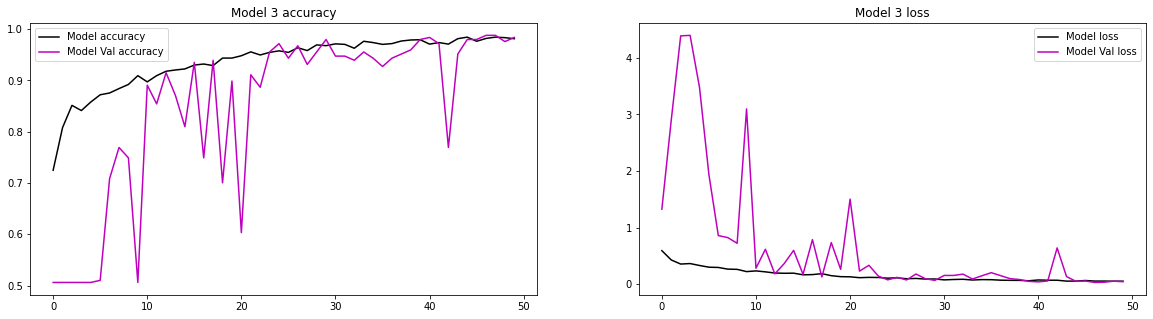

In [ ]:
acc = history4.history["accuracy"]
val_acc = history4.history["val_accuracy"]
loss = history4.history["loss"]
val_loss = history3.history["val_loss"]

epochs = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[20, 5])
ax1.plot(epochs, acc, 'k')
ax1.plot(epochs, val_acc, 'm')
ax1.set_title('Model 4 accuracy')
ax1.legend(['Model accuracy','Model Val accuracy'])

ax2.plot(epochs, loss, 'k')
ax2.plot(epochs, val_loss, 'm')
ax2.set_title('Model 4 loss')
ax2.legend(['Model loss','Model Val loss'])

plt.show()

###Evaluasi Model 4

In [ ]:
loss, acc = model4.evaluate(X_train,Y_train,verbose = 0)
print("Training Loss {:.5f} dan Training Accuracy {:.2f}%".format(loss,acc*100))

Training Loss 0.02996 dan Training Accuracy 99.19%


In [ ]:
loss, acc = model4.evaluate(X_val,Y_val,verbose = 0)
print("Validation Loss {:.5f} dan Validation Accuracy {:.2f}%".format(loss,acc*100))

Validation Loss 0.04127 dan Validation Accuracy 98.38%


In [ ]:
loss, acc = model4.evaluate(X_test,Y_test,verbose = 0)
print("Test Loss {:.5f} dan Test Accuracy {:.2f}%".format(loss,acc*100))

Test Loss 0.07715 dan Test Accuracy 96.80%


In [ ]:
print("model 4")
pred = model4.predict(X_val)
labels = (pred > 0.5).astype(np.int)

print(classification_report(Y_val, labels, target_names = categories))

model 4
              precision    recall  f1-score   support

   non-COVID       1.00      0.97      0.98       122
       COVID       0.97      1.00      0.98       125

    accuracy                           0.98       247
   macro avg       0.98      0.98      0.98       247
weighted avg       0.98      0.98      0.98       247



In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.BuPu):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Model 4


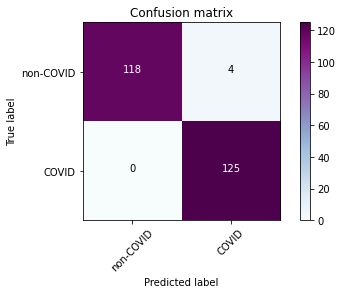

In [ ]:
confusion_mtx = confusion_matrix(Y_val, labels)
print("Model 4")
plot_confusion_matrix(confusion_mtx, classes = categories) 

In [ ]:
cm = pd.DataFrame(confusion_mtx , index = ['non-COVID','COVID'] , columns = ['non-COVID','COVID'])
cm

,non-COVID,COVID
non-COVID,118,4
COVID,0,125


In [ ]:
df = DataFrame(columns=['Kelas Asli','Hasil Prediksi', 'Keterangan'])

kelas_asli = []
hasil_prediksi = []
keterangan = []

for i in Y_val:
  if (i == 0):
    kelas_asli.append("non-COVID")
  else:
    kelas_asli.append("COVID")

for i in labels:
  if (i == 0):
    hasil_prediksi.append("non-COVID")
  else:
    hasil_prediksi.append("COVID")


i = 0
while (i < len(Y_val)):
  if (Y_val[i] == 0):
    if (Y_val[i] == labels[i]):
      keterangan.append("TP")
    else:
      keterangan.append("FP")
  elif(Y_val[i] == 1):
    if (Y_val[i] == labels[i]):
      keterangan.append("TN")
    else:
      keterangan.append("FN")
  i = i+1

df['Kelas Asli'] = kelas_asli
df['Hasil Prediksi'] = hasil_prediksi
df['Keterangan'] = keterangan
df

,Kelas Asli,Hasil Prediksi,Keterangan
0,non-COVID,non-COVID,TP
1,non-COVID,non-COVID,TP
2,non-COVID,non-COVID,TP
3,non-COVID,non-COVID,TP
4,non-COVID,non-COVID,TP
...,...,...,...
242,COVID,COVID,TN
243,COVID,COVID,TN
244,COVID,COVID,TN
245,COVID,COVID,TN


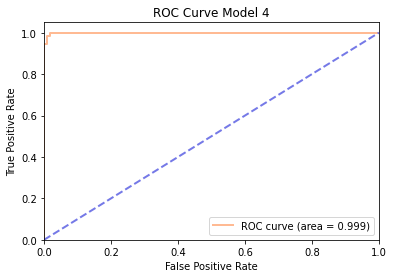

In [ ]:
pred_val = model4.predict(X_val)
fpr, tpr, _ = roc_curve(Y_val, pred_val)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='#ffba93',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='#7579e7', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Model 4')
plt.legend(loc="lower right")
plt.show()

In [ ]:
auc_score = roc_auc_score(Y_val, pred_val)
fpr, tpr, th = roc_curve(Y_val, pred_val)
print('AUC Score Model 4 = ', round(auc_score, 3))

AUC Score Model 4 =  0.999
